# Sentiment Analysis

## Loading Data & Descriptive Analysis

In [0]:
import numpy as np
import pandas as pd

In [0]:
train_df = pd.read_csv("/content/review_train.csv")

In [0]:
test_df = pd.read_csv("/content/review_test.csv")

In [52]:
train_df.columns.difference(test_df.columns)

Index([], dtype='object')

In [53]:
train_df.shape

(14825, 3)

In [54]:
test_df.shape

(3707, 3)

In [0]:
train_df["Source"] = "train"
test_df["Source"] = "test"

In [56]:
train_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [57]:
test_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [0]:
df = pd.concat([train_df, test_df])

In [59]:
df.shape

(18532, 4)

In [60]:
df.head()

,Text,Score,Sentiment,Source
0,"I got a free sample of these once, and now--we...",5,1,train
1,I used to get this Tea when I lived in Washing...,4,1,train
2,This is my all time favorite 'grab and go' sna...,5,1,train
3,This flavor is very good and unexpected. The ...,4,1,train
4,thrilled to have this assortment as i got the ...,4,1,train


In [61]:
df.tail()

,Text,Score,Sentiment,Source
3702,I always have Powerade in the house - for ever...,5,1,test
3703,I tried this coffee on a half dozen quests thi...,5,1,test
3704,The Neccos were exactly what I expected and fr...,5,1,test
3705,I thought I was doing the right thing by getti...,1,0,test
3706,Cugino's chicken noodle soup is pretty tasty. ...,5,1,test


In [62]:
df.describe()

,Score,Sentiment
count,18532.000000,18532.000000
mean,4.277304,0.843784
std,1.319827,0.363070
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## EDA

In [63]:
df.Score.value_counts()

5    12795
4     2842
1     1866
2     1029
Name: Score, dtype: int64

In [64]:
df.Sentiment.value_counts()

1    15637
0     2895
Name: Sentiment, dtype: int64

In [65]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Score,18532.0,4.277304,1.319827,1.0,4.0,5.0,5.0,5.0
Sentiment,18532.0,0.843784,0.363070,0.0,1.0,1.0,1.0,1.0


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 0 to 3706
Data columns (total 4 columns):
Text         18532 non-null object
Score        18532 non-null int64
Sentiment    18532 non-null int64
Source       18532 non-null object
dtypes: int64(2), object(2)
memory usage: 723.9+ KB


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import seaborn as sns

In [0]:
# plt.figure(figsize=(5,5))
# plt.title("Overall comparision between Positive and Negative sentiments")
# sns.barplot(x=df.Sentiment, y=df['Score'])
# plt.ylabel("Score)")

Text(0.5, 1.0, 'Scores Distribution')

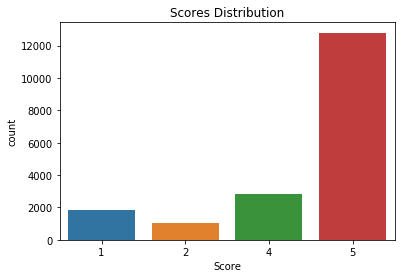

In [70]:
sns.countplot(x='Score', data=df)
plt.title("Scores Distribution")
# sns.barplot(x = df.Score.value_counts().index, y = df.Score.value_counts())

In [0]:
# plt.figure(figsize=(3,5))
# sns.countplot(x='Sentiment', data=df)
# plt.title("Sentiment Distribution")

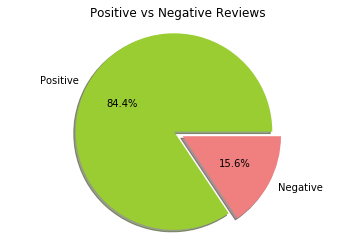

In [72]:
labels = 'Positive', 'Negative'
sizes = df.Sentiment.value_counts()
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=0)
plt.title("Positive vs Negative Reviews")

plt.axis('equal')
plt.show()

In [73]:
corr = df.corr()
print(corr)

              Score  Sentiment
Score      1.000000   0.952582
Sentiment  0.952582   1.000000


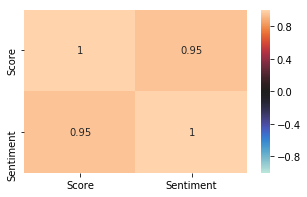

In [74]:
plt.figure(figsize=(5,3))
ax = sns.heatmap(corr,vmin=-1,vmax=1,center=0,annot=True)

## Data Preprocessing

In [75]:
df.isna().sum()

Text         0
Score        0
Sentiment    0
Source       0
dtype: int64

In [76]:
df.duplicated().sum()

433

In [0]:
reviews = np.array(df['Text'])
sentiments = np.array(df['Sentiment'])

In [78]:
reviews.size

18532

In [79]:
sentiments.size

18532

## Text Preprocessor

In [81]:
!pip install textsearch
!pip install contractions
!pip install tqdm

In [82]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# !pip install spacy
import spacy

In [0]:
!python -m spacy validate

In [0]:
!python -m spacy download en

In [0]:
import re
from bs4 import BeautifulSoup
import unicodedata
# import contractions
import spacy

# nlp = spacy.load('en')
ps = nltk.porter.PorterStemmer()


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


# def expand_contractions(text):
#     return contractions.fix(text)


# def spacy_lemmatize_text(text):
#     text = nlp(text)
#     text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
#     return text


def simple_stemming(text, stemmer=ps):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [0]:
# As dependency issues in installing TextSearch and Contractions libraries. Using below logic to handle contractions

In [0]:
import re
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)].lower()
    return c_re.sub(replace, text.lower())


In [0]:
# Examples
print(expandContractions('I ain\'t got time for y\'alls foolishness'))
print(expandContractions('You won\'t live to see tomorrow.'))
print(expandContractions('You\'ve got serious cojones coming in here like that.'))
print(expandContractions('I hadn\'t\'ve enough'))
print(expandContractions('Don\'t you get it?'))

In [0]:
import tqdm

def text_pre_processor(text, html_strip=True, accented_char_removal=True, contraction_expansion=True,
                       text_lower_case=True, text_stemming=False, text_lemmatization=False, 
                       special_char_removal=True, remove_digits=True, stopword_removal=False, 
                       stopword_list=None):
    
    # strip HTML
    if html_strip:
        text = strip_html_tags(text)
    
    # remove extra newlines (often might be present in really noisy text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)
    
#     # expand contractions    
#     if contraction_expansion:
#         text = expand_contractions(text)
        
        # expand contractions    
    if contraction_expansion:
        text = expandContractions(text)
    
    # lemmatize text
    if text_lemmatization:
        text = spacy_lemmatize_text(text) 
        
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)  
        
    # stem text
    if text_stemming and not text_lemmatization:
        text = simple_stemming(text)
        
    # lowercase the text    
    if text_lower_case:
        text = text.lower()
        
        
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text, is_lower_case=text_lower_case, 
                                stopwords=stopword_list)
        
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    text = text.strip()
    
    return text

  
def corpus_pre_processor(corpus):
  norm_corpus = []
  for doc in tqdm.tqdm(corpus):
    norm_corpus.append(text_pre_processor(doc))
  return norm_corpus

In [0]:
document = """<p>Héllo! Héllo! can you hear me! I just heard about <b>Python</b>!<br/>\r\n 
              It's an amazing language which can be used for [Scripting\tWeb development\tBackend development],\r\n\r\n
              Information Retrieval, Natural Language Processing, Machine Learning & Artificial Intelligence!\n
              What are you waiting for? Go and get started.<br/> He's learning, she's learning, they've already\n\n
              got a headstart! GET PYTHON 3.6 NOW!</p>
           """
print(document)

In [0]:
text_pre_processor(document)

## Using TextBlob

In [0]:
# !pip install textblob

In [0]:
import textblob

In [0]:
# Testing just 3 reviews and their sentiments with Predicted Polarity 

for review, sentiment  in zip(reviews[105:108], sentiments[105:108]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    print('PREDICTED Sentiment polarity:', textblob.TextBlob(text_pre_processor(review)).sentiment.polarity)
    print('-'*120)

## Using AFINN

In [0]:
# !pip install afinn

In [0]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [0]:
# Testing just 3 reviews and their sentiments with AFINN Score

for review, sentiment  in zip(reviews[105:108], sentiments[105:108]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    print('PREDICTED Sentiment polarity:', afn.score(text_pre_processor(review)))
    print('-'*120)

## Using VADER

In [0]:
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [0]:
def analyze_sentiment_vader_lexicon(review, 
                                    threshold=0.1,
                                    verbose=False):    
    # analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    # get aggregate scores and final sentiment
    agg_score = scores['compound']
    final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
    if verbose:
        # display detailed sentiment statistics
        positive = str(round(scores['pos'], 2)*100)+'%'
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive,
                                        negative, neutral]],
                                        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                                      ['Predicted Sentiment', 'Polarity Score',
                                                                       'Positive', 'Negative', 'Neutral']], 
                                                              codes=[[0,0,0,0,0],[0,1,2,3,4]]))
        print(sentiment_frame)
    
    return final_sentiment

In [0]:
# Testing just 3 reviews and their sentiments with AFINN Score

for review, sentiment  in zip(reviews[105:108], sentiments[105:108]):
    print("REVIEW: ", review)
    print("SENTIMENT: ", sentiment)
    pred = analyze_sentiment_vader_lexicon(text_pre_processor(review), threshold=0.4, verbose=True)    
    print('-'*120)